# Overview

In this tutorial we will explore the foundations of box localization networks. First we will examine the most common anchor parameterization of boxes at various scales and ratios across different feature map levels. Second we will explore the a popular backbone common to many modern box localization networks: the feature pyramid network. Finally we will dive into specifies regarding a popular high-performing implementation: RetinaNet.

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [1]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 89 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 42.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries:

In [2]:
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, models, layers, optimizers
from jarvis.train import datasets
from jarvis.utils.display import imshow
from jarvis.train.box import BoundingBox

# Data

The data used in this tutorial will consist of kidney tumor CT exams derived from the Kidney Tumor Segmentation Challenge (KiTS). More information about he KiTS Challenge can be found here: https://kits21.kits-challenge.org/. In this exercise, we will use this dataset to derive a model for slice-by-slice kidney segmentation. The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/ct_kits`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [3]:
# --- Download dataset
datasets.download(name='ct/kits')

[ 2022-05-16 03:12:23 ] [====================] 100.000% : Extracting archive (0000818 / 0000818) 

{'code': '/data/raw/ct_kits', 'data': '/data/raw/ct_kits'}

Once downloaded, the `datasets.prepare(...)` method can be used to generate the required python Generators to iterate through the dataset, as well as a `client` object for any needed advanced functionality. As needed, pass any custom configurations (e.g. batch size, normalization parameters, etc) into the optional `configs` dictionary argument. 

To specificy the correct Generator template file, pass a designated `keyword` string. In this tutorial, we will be using abdominal CT volumes that have been preprocessed into 96 x 96 x 96 matrix volumes, each cropped to the right and left kidney, facilitating ease of algorithm training within the Google Colab platform. To select the correct Client template for this task, use the keyword string `2d-bin`. 

In [4]:
# --- Prepare generators
gen_train, gen_valid, client = datasets.prepare(name='ct/kits', keyword='2d-bin', custom_layers=True)

The created generators yield a total of `batch['size']` training samples based on the specified batch size. As before, each iteration yields dictionary of model inputs, `xs`. In the current example, there is just a single input image `xs['dat']` and a single target `xs['lbl']`. Let us examine the generator data:

In [5]:
# --- Yield one example
xs, _ = next(gen_train)

# --- Print dict keys
for k, v in xs.items():
    print('key = {} : shape = {}'.format(k.ljust(7), v.shape))

key = dat     : shape = (16, 1, 96, 96, 1)
key = lbl     : shape = (16, 1, 96, 96, 1)


### KITS Data

The input images in the variable `dat` are matrices of shape `1 x 96 x 96 x 1`. Note that even though the images here are 2D in shape, the full matrix is a 3D tensor `(z, y, x)` where `z = 1` in this implementation. Note that although the 3rd z-axis dimension is redundant here (for a single slice input), many of our more complex models and architectures will commonly require a full 3D tensor. Because of this, we will directly use 3D convolutions throughout the tutorial materials for consistency.

Use the following lines of code to visualize using the `imshow(...)` method:

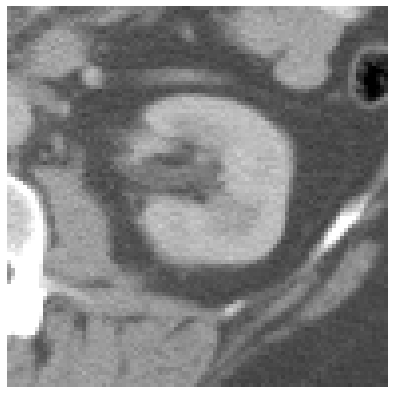

In [6]:
# --- Show the first example
imshow(xs['dat'][0])

Use the `montage(...)` function to create an N x N mosaic of all images:

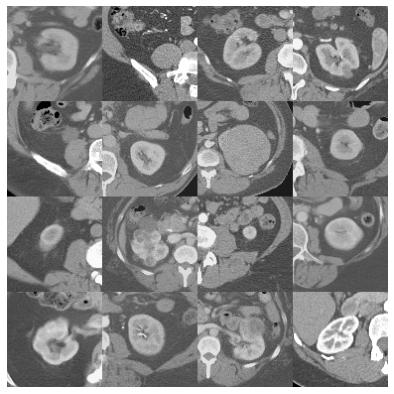

In [7]:
# --- Show "montage" of all images
imshow(xs['dat'])

### Kidney masks

The ground-truth labels are binary masks of the same matrix shape as the model input:

In [8]:
print(xs['lbl'][0].shape)

(1, 96, 96, 1)


Use the `imshow(...)` method to visualize the ground-truth tumor mask labels:

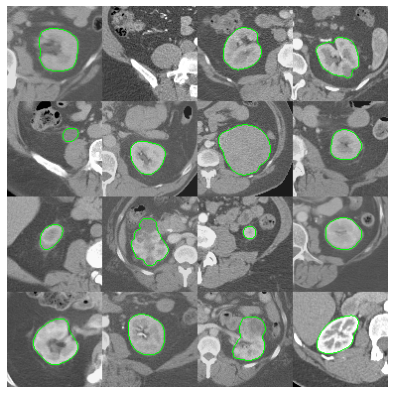

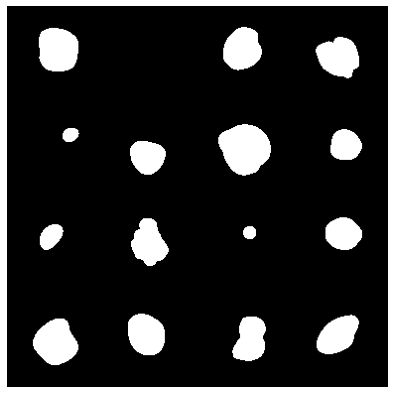

In [9]:
# --- Show tumor masks overlaid on original data
imshow(xs['dat'], xs['lbl'])

# --- Show tumor masks isolated
imshow(xs['lbl'])

# Box Parameterization

Recall the common parameterization of boxes across an image using a grid of anchors:

![Box Parameterization](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2020/notebooks/box_localization/pngs/box_params.png)

At each anchor location, a total of **A** anchors may be defined spanning a variety of:

* **aspect ratios**: 1:1, 2:1, 1:2, etc ...
* **scales**: 2 ** 0, 2 ** (1/3), 2 ** (2/3), etc ...

For each **A** number of anchors, there are two separate predictions:

* **K**-element logit score representing a binary prediction of whether or not the *k-th* class is present in the box
* **4**-element box fine-tuning representing the shift in the height, width, y- and x-coordinates from base box

### Anchor grid sizes

The H x W size of an anchor grid (e.g. and thus implicitly the correspond box size) is commonly referenced by the **number of subsamples** required relative to the original full image shape. For example, if an original image is (N, N) in shape, then the first subsampled feature map is (N / 2, N / 2), the second subsampled featured map is (N / 4, N / 4), etc...

In this example, the original input images are (96, 96) MR images. Thus the following feature maps (prefixed with `c`) may be defined:

* **c1**: 48 x 48 anchor grid
* **c2**: 24 x 24 anchor grid
* **c3**: 12 x 12 anchor grid
* **c4**: 6 x 6 anchor grid

... and so on. By default, it is most common to start at the `c2` or `c3` level and proceed to include 2 to 5 different resolutions depending on the desired target.

### `BoundingBox`

The `BoundingBox` class as part of the `jarvis-md` library facilitates definition and manipulation of boxes parameterized using the above standard notation. The object initializer has the following arguments:

```
(iter)   image_shape     : original 2D image shape
(int)    classes         : number of non-background classes
(iter)   c               : feature maps to use; c1 = 1st subsample, c2 = 2nd subsample, etc
(iter)   anchor_shapes   : base shape of anchors in each feature map
(iter)   anchor_scales   : scales of each anchor parameterized as 2 ** (i/3)
(iter)   anchor_ratios   : aspect ratios of each anchor
(float)  iou_upper       : upper IoU used for pos boxes
(float)  iou_lower       : lower IoU used for neg boxes
(float)  iou_nms         : IoU used for non-max supression
(int)    box_padding     : padding for ground-truth boxes
(bool)   separate_maps   : if True, create parameters for each feature map separately
```

In [10]:
# --- Create BoundingBox
bb = BoundingBox(
    image_shape=(96, 96),
    classes=1,
    c=[3, 4],
    anchor_shapes=[16, 32],
    anchor_scales=[0, 1, 2],
    anchor_ratios=[0.5, 1, 2],
    iou_upper=0.5,
    iou_lower=0.2)

This code will initialze all anchors and template boxes based on our specifications:

In [11]:
# =============================
# PRINT BOUNDING BOX SPECS
# =============================

# --- Print grid sizes
print('---------------------------------------')
print('Anchor Grid Sizes')
print(bb.params['anchor_gsizes'])

# --- Print template anchor box shapes
print('---------------------------------------')
print('Anchor Template Box Shapes')
print(bb.params['anchor_shapes'])

# --- Print anchor details
print('---------------------------------------')
print('Anchor scales: {}'.format(bb.params['anchor_scales']))
print('Anchor ratios: {}'.format(bb.params['anchor_ratios']))

print('---------------------------------------')
print('Total anchors (A) = {}'.format(
    len(bb.params['anchor_scales']) * 
    len(bb.params['anchor_ratios'])))
print('Total classes (k) = {}'.format(bb.params['classes']))

---------------------------------------
Anchor Grid Sizes
[[12, 12], [6, 6]]
---------------------------------------
Anchor Template Box Shapes
[16, 32]
---------------------------------------
Anchor scales: [0, 1, 2]
Anchor ratios: [0.5, 1, 2]
---------------------------------------
Total anchors (A) = 9
Total classes (k) = 1


Note that other parameters can be found in `bb.params`.

**Checkpoint**: How many boxes in total are defined by the specifications above?

### Ground-truth

Recall that the ground-truth predictions the box-localization CNN must produce are variable depending on the box parameterization chosen above. Predictions at *multiple feature map resolutions* must be provided for both the classification task (e.g. determine which boxes are positive) and regression task (e.g. determine what modifications are needed to template boxes to create final boxes). 

**Checkpoint**: How many different feature map predictions must the CNN generate in the box parameterization chosen above? What are the shapes for all predicted feature maps? Use `bb.params['inputs_shapes']` to confirm your calculations.

The `BoundingBox` object can create ground-truth box parameterizations using either label masks (e.g. provided in this tutorial) or boxes provided in anchor-style format e.g `[y0, x0, y1, x1]`. To generate ground-truth from a provided mask, use the `bb.convert_msk_to_box(...)` method:

In [12]:
# --- Create box ground-truths
box = bb.convert_msk_to_box(xs['lbl'][0])

Do the parameterized box ground-truths match your expected tensor shapes?

Raw box parameterizations are difficult to visualize and/or check. Instead to *post-process* box parameterizations, use one of the following methods:

* `bb.convert_box_to_anc(...)`: method to convert box to anchors (e.g. `[y0, x0, y1, x1]`)
* `bb.convert_box_to_msk(...)`: method to convert box to mask label for visualization

For both methods, the `apply_deltas=[True/False]` flag can be used to specify whether or not to apply the box refinements (e.g. regression network predictions).

In [13]:
# --- Convert box to anchors
anchors, classes = bb.convert_box_to_anc(box, apply_deltas=False)

print('---------------------------------------')
print('\nGround-truth template boxes (before refinement):\n')
print(anchors)

anchors, classes = bb.convert_box_to_anc(box, apply_deltas=True)

print('---------------------------------------')
print('\nGround-truth template boxes (after refinement):\n')
print(anchors)

---------------------------------------

Ground-truth template boxes (before refinement):

[[ 0.         30.04060723 67.91878555 65.95939277]
 [32.         32.         64.         64.        ]
 [19.49124102 33.74562051 76.50875898 62.25437949]
 [27.8412632  27.8412632  68.1587368  68.1587368 ]
 [33.74562051 19.49124102 62.25437949 76.50875898]
 [12.08121445 30.04060723 83.91878555 65.95939277]
 [22.60158317 22.60158317 73.39841683 73.39841683]
 [22.60158317 38.60158317 73.39841683 89.39841683]
 [30.04060723 28.08121445 65.95939277 96.        ]]
---------------------------------------

Ground-truth template boxes (after refinement):

[[22. 32. 66. 72.]]


**Checkpoint**: why are the post-refinement boxes exactly identical?

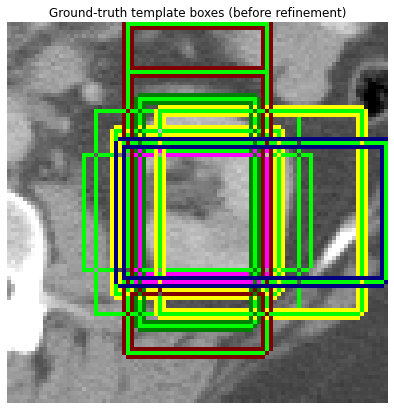

In [14]:
# --- Convert box to mask (for visualization)
msk = bb.convert_box_to_msk(box, apply_deltas=False)
imshow(xs['dat'][0, ..., 0], msk, title='Ground-truth template boxes (before refinement)')

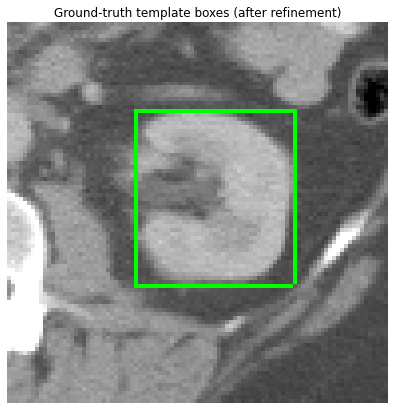

In [15]:
# --- Convert box to mask (for visualization)
msk = bb.convert_box_to_msk(box, apply_deltas=True)
imshow(xs['dat'][0, ..., 0], msk, title='Ground-truth template boxes (after refinement)')

**Checkpoint**: What happens to the appearance of boxes with variations in:

* grid sizes (`c` values)
* anchor shapes
* anchor aspect ratios
* anchor scales

### Generators

To convert the current mask (segmentation output) generators into bounding box labels, use a nested Python generators using the `bb.convert_msk_to_box(...)` method as demonstrated above. 

In [16]:
def box_generator(G):
    
    for xs, _ in G:
        
        # --- Convert mask into bounding-box paramaterization
        msk = xs.pop('lbl')
        box = bb.convert_msk_to_box(msk=msk)
        
        # --- Update xs dictionary
        xs.update(box)
        
        yield xs

Use the following lines of code to initialize training and validation generators:

In [17]:
# --- Prepare generators
gen_train, gen_valid = client.create_generators()
gen_train = box_generator(G=gen_train)
gen_valid = box_generator(G=gen_valid)

Visualize within the following code:

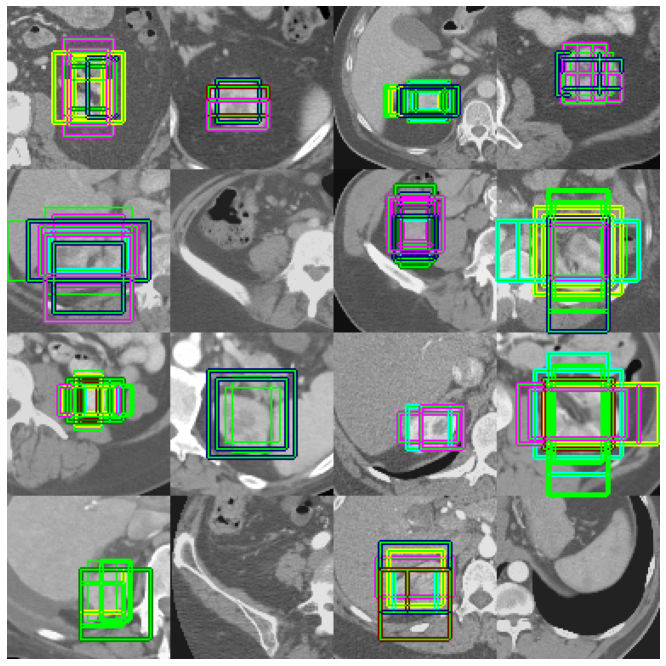

In [18]:
# --- Show first iteration
xs = next(gen_train)
msk = bb.convert_box_to_msk(box=xs, apply_deltas=False)
imshow(xs['dat'][:, 0], msk[:, 0], figsize=(12, 12))

# Feature Pyramid Network

Now that the inputs and outputs of the CNN have been defined, the goal is to implement a network architecture that is able to perform the desired mapping via a feature pyramid network. The contracting arm of a FPN architecture is nonspecific and can be implemented using any standard architecture.

Let us define the contracting arm as follows:

### Contracting arm

In [19]:
# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same'}

# --- Define lambda functions
conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(1, 2, 2))))

# --- Input input
x = Input(shape=(None, 96, 96, 1), dtype='float32')

# --- Define contracting layers
l1 = conv1(8, x)
l2 = conv1(16, conv2(16, l1))
l3 = conv1(24, conv2(24, l2))
l4 = conv1(32, conv2(32, l3))
l5 = conv1(48, conv2(48, l4))

**Checkpoint**: The most important part here is simply to ensure that the deepest layer is at least the same size (or smaller) than the smallest anchor grid size needed for the box network. How can we confirm this?

### Expanding arm

To create layers of the expanding arm of the FPN, two special new operations must be defined.

![Box Parameterization](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2020/notebooks/box_localization/pngs/fpn.png)

First, to upsample an FPN feature map, a simple parameterless interpolation is used. The corresponding Tensorflow class is the `layers.UpSampling3D(...)` object. Let us define the corresponding lambda function here:

In [20]:
# --- Define zoom
zoom = lambda x : layers.UpSampling3D(
    size=(1, 2, 2))(x)

Additionally, in order to add the corresponding contract arm layer, recall that a 1 x 1 x 1 convolution must be used to **match feature map channels (filters)**. Recall that all FPN output maps must have the same identical number of channels (in our case, 64). Let us define the corresponding lambda function here:

In [21]:
# --- Define 1 x 1 x 1 projection
proj = lambda filters, x : layers.Conv3D(
    filters=filters,
    strides=1,
    kernel_size=(1, 1, 1),
    padding='same',
    kernel_initializer='he_normal')(x)

Now we are ready to define the expanding layers. Recall that we only need to create the required anchor grid sizes as defined above:

* c4: 6 x 6
* c3: 12 x 12

Once these have been created, there is no need to define more expansions.

In [22]:
# --- Define expanding layers
l6 = proj(64, l5)
l7 = zoom(l6) + proj(64, l4)

To finalize the `c3` and `c4` feature maps, simply apply one final 3 x 3 convolution to each intermediate tensor:

In [23]:
# --- Finalize feature maps
c4 = conv1(64, l6)
c3 = conv1(64, l7)

# RetinaNet

Now that the FPN backbone has been created, we must finalize the feature maps to perform the classification and regression tasks necessary to predict boxes. There are many ways to implement this final mapping; we will derive a method based off of the approach described in the RetinaNet paper. This implementation is quite simple (most of the "power" lies in the focal loss function) and simply requires that at each feature map resolution, a classifier head is created to perform the necessary classification and regression tasks.

![Box Parameterization](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2020/notebooks/box_localization/pngs/retinanet.png)

In the original RetinaNet paper, four convolutional blocks are used, however in the context of medical imaging problems (e.g. less data, more homogenous predictions), we will just use two blocks.

In [24]:
# --- Determine filter sizes
logits = {}
K = 1
A = 9

# --- C3
c3_cls = conv1(64, conv1(64, c3))
c3_reg = conv1(64, conv1(64, c3))
logits['cls-c3'] = layers.Conv3D(filters=(A * K), name='cls-c3', **kwargs)(c3_cls)
logits['reg-c3'] = layers.Conv3D(filters=(A * 4), name='reg-c3', **kwargs)(c3_reg)

# --- C4
c4_cls = conv1(64, conv1(64, c4))
c4_reg = conv1(64, conv1(64, c4))
logits['cls-c4'] = layers.Conv3D(filters=(A * K), name='cls-c4', **kwargs)(c4_cls)
logits['reg-c4'] = layers.Conv3D(filters=(A * 4), name='reg-c4', **kwargs)(c4_reg)

At last, the `backbone` can be formally created:

In [25]:
# --- Create model
backbone = Model(inputs=x, outputs=logits)

# Training model

Next, the `backbone` model architecture is wrapped in a second model with additional layer(s) that define optimization behavior including loss function derivations.

### Inputs

As before, we start by defining all `inputs` into our new *wrapper* model. For box localization networks recall that the loss function is defined across multiple resolutions (`c3`, `c4`, etc) and for both classification and regression tasks. Thus, the `xs` input has multiple entries and the corresponding `inputs` dict here much be adjusted accordingly. The use of these additional model inputs will be discussed further in the following sections later in this tutorial. For now, let us first check the shape of the `xs` entries:

In [26]:
# --- Print shapes of all model inputs
{k: v.shape for k, v in xs.items()}

{'cls-c3': (16, 1, 12, 12, 9),
 'cls-c3-msk': (16, 1, 12, 12, 9),
 'cls-c4': (16, 1, 6, 6, 9),
 'cls-c4-msk': (16, 1, 6, 6, 9),
 'dat': (16, 1, 96, 96, 1),
 'reg-c3': (16, 1, 12, 12, 36),
 'reg-c3-msk': (16, 1, 12, 12, 36),
 'reg-c4': (16, 1, 6, 6, 36),
 'reg-c4-msk': (16, 1, 6, 6, 36)}

Use the following Python dict comprehension to create corresponding `Input` objects for each entry:

In [27]:
inputs = {k: Input(shape=[None] + list(v.shape[2:]), dtype='float32', name=k) for k, v in xs.items()}

Using this `inputs` Python dictionary, let us first recreate the CNN model operations by **reusing** the `backbone` object that we already defined. Doing so means that our new *wrapper* model is explicitly derived from the `backbone`. Any updates applied to our new *wrapper* model are propogated to the `backbone` model and vice versa. 

In [28]:
# --- Define first step of new wrapper model
logits = backbone(inputs['dat'])

### Focal loss

To account for inherent class imbalance, box localization models may be implemented with **focal loss**. As you recall, the **focal loss** function gradually titrates the contribution of any given prediction such that more confident correct predictions over time become weighted less than incorrect predictions.

![Focal Loss](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2022/notebooks/box_localization/pngs/focal_loss.png)

Focal loss is not a default loss function built into the standard Tensorflow 2 / Keras library. Accordingly, use the following custom implementation of focal loss:

In [29]:
def focal_sigmoid_ce(y_true, y_pred, weights=1.0, scale=1.0, gamma=2.0, alpha=0.25, **kwargs):
    """
    Method to implement focal sigmoid (binary) cross-entropy loss

    """
    # --- Calculate standard cross entropy with alpha weighting
    loss = tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true, logits=y_pred, pos_weight=alpha)

    # --- Calculate modulation to pos and neg labels 
    p = tf.math.sigmoid(y_pred)
    modulation_pos = (1 - p) ** gamma
    modulation_neg = p ** gamma

    mask = tf.cast(y_true, dtype=tf.bool)
    modulation = tf.where(mask, modulation_pos, modulation_neg)

    return tf.math.reduce_mean(modulation * loss * weights * scale)

### Huber loss

For box regression tasks, it is common to use a combination of both L1 and L2 type losses. Most commonly the desired effect is to use an L1 loss early in training (when the loss values are large) and to transition to a smoother L2 loss as the algorithm converges. One such implementation of this smooth regression loss function is the Huber loss. 

![Huber Loss](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2022/notebooks/box_localization/pngs/huber_loss.png)

More information can be found here: https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber.

In [30]:
def huber(y_true, y_pred, weights=1.0, delta=1.0, **kwargs):
    """
    Method to calculate mixed L1/L2 Huber loss
    
    """
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    
    loss = tf.keras.losses.huber(
        y_true=y_true,
        y_pred=y_pred,
        delta=delta)
    
    return tf.math.reduce_mean(loss * weights)

### Box metrics

Finally, to keep track of classification performance, the use of the standard accuracy metric is suboptimal as the number of correct box predictions will quickly saturate to 100% (as the number of negative boxes >> number of positive boxes). In fact generally speaking, any metric that tracks performance of negative box predictions gtend not be very useful.

Instead, consider the use of **sensitivity** and **PPV**:

* sensitivity (recall): TP / (TP + FN)
* positive predictive value (precision): TP / (TP + FP)

In [31]:
def sigmoid_ce_sens(y_true, y_pred, weights=None, threshold=0.5, **kwargs):
    """
    Method to implement sensitivity (recall) on raw sigmoid (binary) cross-entropy logits

    """
    p = tf.math.sigmoid(y_pred)
    tp = (p > threshold) & (y_true > 0)
    
    if weights is not None:
        tp = tp & (weights != 0)
        y_true = (y_true > 0) & (weights != 0)

    num = tf.math.count_nonzero(tp) 
    den = tf.math.count_nonzero(y_true)

    num = tf.cast(num, tf.float32)
    den = tf.cast(den, tf.float32)

    return tf.math.divide_no_nan(num, den)

In [32]:
def sigmoid_ce_ppv(y_true, y_pred, weights=None, threshold=0.5, **kwargs):
    """
    Method to implement PPV (precision) on raw sigmoid (binary) cross-entropy logits

    """
    p = tf.math.sigmoid(y_pred)
    pp = p > threshold
    tp = pp & (y_true == 1)
    
    if weights is not None:
        tp = tp & (weights != 0)
        pp = pp & (weights != 0)

    num = tf.math.count_nonzero(tp) 
    den = tf.math.count_nonzero(pp)

    num = tf.cast(num, tf.float32)
    den = tf.cast(den, tf.float32)
    
    return tf.math.divide_no_nan(num, den)

### Masked loss and metric functions

As you recall, although boxes classification and regression ground truth values are calculated for **every box** per image, only a subset of boxes are used for algorithm training:

* `cls` network: only boxes with IoU > 0.5 (positive) and IoU < 0.2 (negative)
* `reg` network: only boxes that correspond to a positive classification

To account for this, a sample weight mask is passed into the `weights` argument in each of the loss functions defined above. The relevant masking tensor is generated by the `bb.convert_box_to_msk(...)` method above. 

### Losses and Metrics

To summarize, the following losses and metrics need to be defined:

**Classification losses**: box prediction (presence or absence of box in each individual anchor map)

* `cls-c3`: 12 x 12 grid of focal loss values (track **metrics** with *sensitivity* and *PPV*)
* `cls-c4`: 6 x 6 grid of focal loss values (track **metrics** with *sensitivity* and *PPV*)

In [33]:
# =============================================
# CLASSIFICATION
# =============================================

losses = {}
metric = {}

for key in ['cls-c3', 'cls-c4']:
    
    # --- Define focal loss
    losses[key] = focal_sigmoid_ce(
        y_true=inputs[key],
        y_pred=logits[key],
        weights=inputs[key + '-msk'])
    
    # --- Define sensitivity
    metric[key + '-sen'] = sigmoid_ce_sens(
        y_true=inputs[key],
        y_pred=logits[key],
        weights=inputs[key + '-msk'])
    
    # --- Define PPV
    metric[key + '-ppv'] = sigmoid_ce_ppv(
        y_true=inputs[key],
        y_pred=logits[key],
        weights=inputs[key + '-msk'])

**Regression losses**: box refinement (fine-tuning of each positive box)

* `reg-c3`: 12 x 12 grid of Huber (L1/L2) losses
* `reg-c4`: 6 x 6 grid of Huber (L1/L2) losses

In [34]:
# =============================================
# REGRESSION
# =============================================

for key in ['reg-c3', 'reg-c4']:
    
    # --- Define Huber loss
    losses[key] = huber(
        y_true=inputs[key],
        y_pred=logits[key],
        weights=inputs[key + '-msk'])

### Create model

Now let us create the new wrapper model. The inputs are defined above already in our `inputs` Python dictionary. As outputs, let us return the tensors stored in the `logits` dict. We will name this new wrapper model `training` because it will be used for training only. 

In [35]:
training = Model(inputs=inputs, outputs=logits)

Now let's add the `loss` and `metric` tensors we defined above to the new `training` model:

In [36]:
# --- Add losses
for key, l in losses.items():
    training.add_loss(l)

# --- Add metric
for key, m in metric.items():
    training.add_metric(m, name=key)

### Compile model

 To prepare the model for learning, a graph must be **compiled** with a strategy for optimization.

In [37]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=2e-4)

# --- Compile model
training.compile(optimizer=optimizer)

# Training

### In-memory data

For moderate sized datasets which are too large to fit into immediate hard-drive cache, but small enough to fit into RAM memory, it is often times a good idea to first load all training data into RAM memory for increased speed of training. The `client` can be used for this purpose as follows:

In [38]:
# --- Load data into memory for faster training
client.load_data_in_memory()

[ 2022-05-16 03:12:49 ] [====================] 100.000% : Iterating | 000402    

Now, let us train the model:

In [39]:
# --- Train model
training.fit(
    x=gen_train, 
    steps_per_epoch=100, 
    epochs=20,
    validation_data=gen_valid,
    validation_steps=100,
    validation_freq=5)

Epoch 1/20
100/100 [==============================] - 55s 509ms/step - loss: 0.0955 - cls-c3-sen: 0.1101 - cls-c3-ppv: 0.0167 - cls-c4-sen: 0.1850 - cls-c4-ppv: 0.3425
Epoch 2/20
100/100 [==============================] - 52s 523ms/step - loss: 0.0084 - cls-c3-sen: 0.0022 - cls-c3-ppv: 0.0395 - cls-c4-sen: 0.1461 - cls-c4-ppv: 0.7841
Epoch 3/20
100/100 [==============================] - 53s 525ms/step - loss: 0.0054 - cls-c3-sen: 4.1667e-04 - cls-c3-ppv: 0.0100 - cls-c4-sen: 0.1670 - cls-c4-ppv: 0.8339
Epoch 4/20
100/100 [==============================] - 53s 524ms/step - loss: 0.0044 - cls-c3-sen: 0.0000e+00 - cls-c3-ppv: 0.0000e+00 - cls-c4-sen: 0.2750 - cls-c4-ppv: 0.9023
Epoch 5/20
100/100 [==============================] - 65s 655ms/step - loss: 0.0036 - cls-c3-sen: 4.7619e-04 - cls-c3-ppv: 0.0100 - cls-c4-sen: 0.3747 - cls-c4-ppv: 0.9261 - val_loss: 0.0037 - val_cls-c3-sen: 2.1277e-04 - val_cls-c3-ppv: 0.0100 - val_cls-c4-sen: 0.3021 - val_cls-c4-ppv: 0.9226
Epoch 6/20
100/100 [=

# Evaluation

To test the trained model, the following steps are required:

* load data
* use `model.predict(...)` to obtain logit scores
* use `BoundingBox` object to convert predictions to anchors or masks
* compare prediction with ground-truth
* serialize in Pandas DataFrame

Recall that the generator used to train the model simply iterates through the dataset randomly. For model evaluation, the cohort must instead be loaded manually in an orderly way. For this tutorial, we will create new **test mode** data generators, which will simply load each example individually once for testing. 

In [40]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True)
test_train = box_generator(test_train)
test_valid = box_generator(test_valid)

**Important note**: although the model is trained using 2D slices, there is nothing to preclude passing an entire 3D volume through the model at one time (e.g. consider that the entire 3D volume is a single *batch* of data). In fact, typically performance metrics for medical imaging models are commonly reported on a volume-by-volume basis (not slice-by-slice). Thus, use the `expand=True` flag in `client.create_generators(...)` as above to yield entire 3D volumes instead of slices.

In [41]:
# --- Run entire volume through model
x = next(test_train)
box = training.predict(x)

[ 2022-05-16 03:32:16 ] [>...................] 0.312% : Iterating | 000001      

### Calculating IoUs

The logits are the raw predictions from the model, but to generate the corresponding boxes several post-processing steps are needed. First the positive boxes must be identified from the classification network. Then, the predicted template boxes need to be refined using the regression network:

![Box Parameterization](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2020/notebooks/box_localization/pngs/regression.png)

The `BoundingBox` object can be used to perform these steps:

* `bb.convert_box_to_msk(...)`: convert box predictions into 3D mask (primarily visualization)
* `bb.convert_box_to_anc(...)`: convert box predictions into anchors (`[y0, x0, y1, x1]`) (calculate IoUs)

In [42]:
# --- Convert to anchors
anchors, classes = bb.convert_box_to_anc(box)

**Checkpoint**: what do these anchors and classes represent?

As seen in the ground-truth overlays at the beginning of this tutorial, a number of boxes may be classified for each single ground-truth box. Accordinging, during inference a number of ground-truth boxes may be triggered. To prune this boxes, use **non-max suppression**, a technique that removes all boxes that above a certain IoU threshold with the highest scoring box. 

Test several different IoU thresholds to its effect on box outputs:

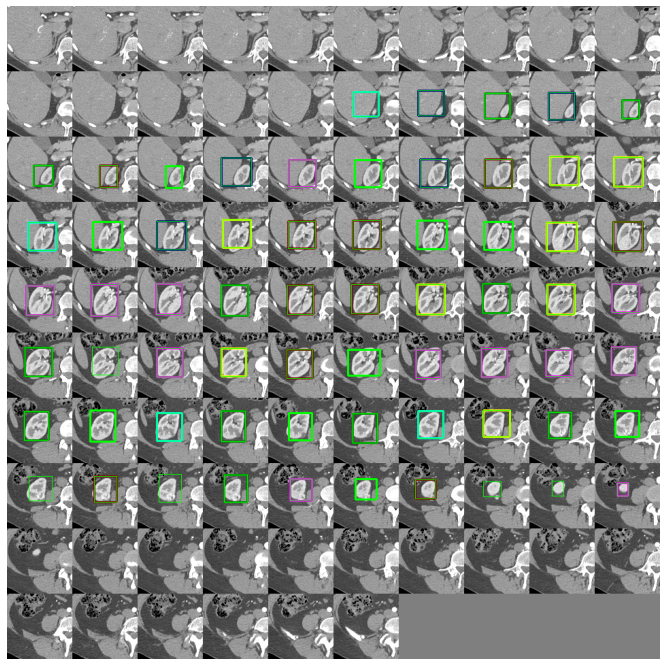

In [43]:
# --- Show various boxes at different NMS thresholds
msk = bb.convert_box_to_msk(box, iou_nms=0.2)
imshow(x['dat'][0], msk[0], figsize=(12, 12))

Now that the specific prediction boxes have been isolated, compare them with the ground truth boxes using the `bb.calculate_ious(...)` method. This function will compare a given single box with a list of many ground-truth anchors. The maximum overlap generated represents the IoU value for the given prediction box:

In [44]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True)
test_train = box_generator(test_train)
test_valid = box_generator(test_valid)

ious = {
    'med': [],
    'p25': [],
    'p75': []}

for x in test_valid:
    
    # --- Predict
    box = training.predict(x)
        
    # --- Convert predictions to anchors
    anchors_pred, _ = bb.convert_box_to_anc(box, iou_nms=0.2)
    
    # --- Convert ground-truth to anchors
    anchors_true, _ = bb.convert_box_to_anc(x)
    
    # --- Calculate IoUs
    curr = []
    for pred, true in zip(anchors_pred, anchors_true):
        for p in pred:
            iou = bb.calculate_ious(box=p, anchors=true)
            if iou.size > 0:
                curr.append(np.max(iou))
            else: 
                curr.append(0)
    
    if len(curr) == 0:
        curr = [0]
        
    ious['med'].append(np.median(curr))
    ious['p25'].append(np.percentile(curr, 25))
    ious['p75'].append(np.percentile(curr, 75))
    
ious = {k: np.array(v) for k, v in ious.items()}

[ 2022-05-16 03:33:25 ] [====================] 100.000% : Iterating | 000081    

### Running evaluation

In [45]:
# --- Define columns
df = pd.DataFrame(index=np.arange(ious['med'].size))
df['iou_median'] = ious['med']
df['iou_p-25th'] = ious['p25']
df['iou_p-75th'] = ious['p75']

# --- Print accuracy
print(df['iou_median'].median())
print(df['iou_p-25th'].median())
print(df['iou_p-75th'].median())

0.7598397135734558
0.6740036904811859
0.8238999843597412


## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `backbone.save()` and `backbone.load_model()` methods. 

In [46]:
# --- Serialize a model
backbone.save('./model.hdf5')

In [47]:
# --- Load a serialized model
del backbone
backbone = models.load_model('./model.hdf5', compile=False)

# Exercises

Bounding box algorithms such as RetinaNet require careful tuning of many hyperparameters to define the distribution of template boxes and post-processing of model predictions. What is the effect of modifying these hyperparameters, and how do you choose good initial values for medical imaging problems?

### Exercise 1

When defining a grid of template boxes, there are at six different hyperparameters to consider:

```
(iter)   c               : feature maps to use; c1 = 1st subsample, c2 = 2nd subsample, etc
(iter)   anchor_shapes   : base shape of anchors in each feature map
(iter)   anchor_scales   : scales of each anchor parameterized as 2 ** (i/3)
(iter)   anchor_ratios   : aspect ratios of each anchor
(float)  iou_upper       : upper IoU used for pos boxes
(float)  iou_lower       : lower IoU used for neg boxes
```

These key hyperparameters dictate the behavior of the `BoundingBox` object. What happens when you modify any of these hyperparameter values? 

When calibrating a bounding box model, one factor to optimize is the total number and distribution of ground-truth bounding boxes for any given single target object. Because medical imaging problems tend to focus on sparse object detection (e.g., one or few number of objects per input), a good initial heuristic is to ensure at least 5-10+ template ground-truth boxes are available for each single target object. Additionally, it is computationally efficient to ensure that all feature map resolutions are used e.g., if you have one or several feature map resolutions that are never positive, then you should simply remove these resolutions from the box parameterization.

How do we ensure that these criteria are met? Use the following code cell to experiment:

### Exercise 2

During inference, it is important to carefully collapse near overlapping boxes in single discrete predictions using a non-max suppression technique. How does modification of the NMS threshold affect algorithm-generated box predictions? How does the total number of target objects and potential object overlap affect tuning of this parameter?

Use the following code cell to experiment: